<a href="https://colab.research.google.com/github/DrAlexSanz/Image-SR/blob/master/Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The end goal of this is to create an upsampling of given pictures (2x, at least for starters). There are many interpolation and deep learning methods/models to achieve this. In my opinion, after reading the papers I could find and considering my (lack of) resources I chose to use an autoencoder approach.

The idea is to train an autoencoder to downsample and then upsample the pictures. This way, I will input the original high resolution (HR) image and I expect to obtain an equivalent generated HR image.

A priori I can make a CNN to obtain a generated LR image from my HR image. The network would be trained using the original LR pictures. Then I can create a DeCNN to obtain the generated HR image.

I don't want to obtain a bigger image in cm, but in resolution. The idea is to start with an image of (x, y) pixels and end up with (x, y) pixels. This aims to de-square the pictures when you upsample by interpolating. Nearest neighbour, linear, cubic, etc. tend to produce artifacts, aliasing and other problems. Basically I will resize the LR image (using scikit image or something like this) to have the same number of pictures as the HR one and then run it through the autoencoder. Making a network that does it all together is for the next version. Start simple.

Check these videos for reference.

[Resizing images](https://youtu.be/AqscP7rc8_M)

[Bicubic interpolation](https://www.youtube.com/watch?v=poY_nGzEEWM)

So the idea is to implement an encoder to obtain a downsampled image. Then this downsampled image goes to the decoder and it generates a sharper image.

Cloning is going to take a while (around 2 min.) but it's worth it. I can keep files there cheaply and I don't have the resources to keep them in an easily accessible place. Sorry github/google people. I'm poor :(

In [0]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os, shutil


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [0]:
# !rm -rf Image-SR

# !git clone https://github.com/DrAlexSanz/Image-SR.git



In [3]:
os.chdir("/content/drive/My Drive/Image-SR")
os.remove("ISR_utils.py")
!wget https://raw.githubusercontent.com/DrAlexSanz/Image-SR/master/ISR_utils.py
from ISR_utils import *

--2019-10-03 07:55:14--  https://raw.githubusercontent.com/DrAlexSanz/Image-SR/master/ISR_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6294 (6.1K) [text/plain]
Saving to: ‘ISR_utils.py’

ISR_utils.py        100%[===================>]   6.15K  --.-KB/s    in 0.001s  

2019-10-03 07:55:14 (8.42 MB/s) - ‘ISR_utils.py’ saved [6294/6294]



I could load the pictures into a np array. This would be feasible with smaller pictures. I included a function for that in the utils file because I had it. Since loading all the pictures is not feasible I have to use flow from directory. I don't want to perform data augmentation now, that I will do it in the next version.

In [0]:
copy_files()

Someone decided to include a 2x in the name of the LR pictures and that only creates problems. Remove it to have the same file names in each directory.

In [0]:
path_train_LR = "/content/Image-SR/train/LR"
path_test_LR = "/content/Image-SR/test/LR"

rename(path_train_LR)
rename(path_test_LR)

First things first. I have train and test pictures, but no validation set. Since I don't have a lot of data, I will use let's say the last 50 images from the train examples to create my validation set. The pictures don't follow any order that I can detect so I don't need to sample randomly.

In [0]:
make_val_set()

Now I want to explore the image dimensions. I know the height and the width of the HR one are divided by 2 in the LR version. But all of them have a different number of pixels. Let's explore the dataset to fix a dimension for the input and output.

The mean of the heights is:  1970
The median of the heights is:  2040.0
The mean of the widths is:  1435
The median of the widths is:  1356.0


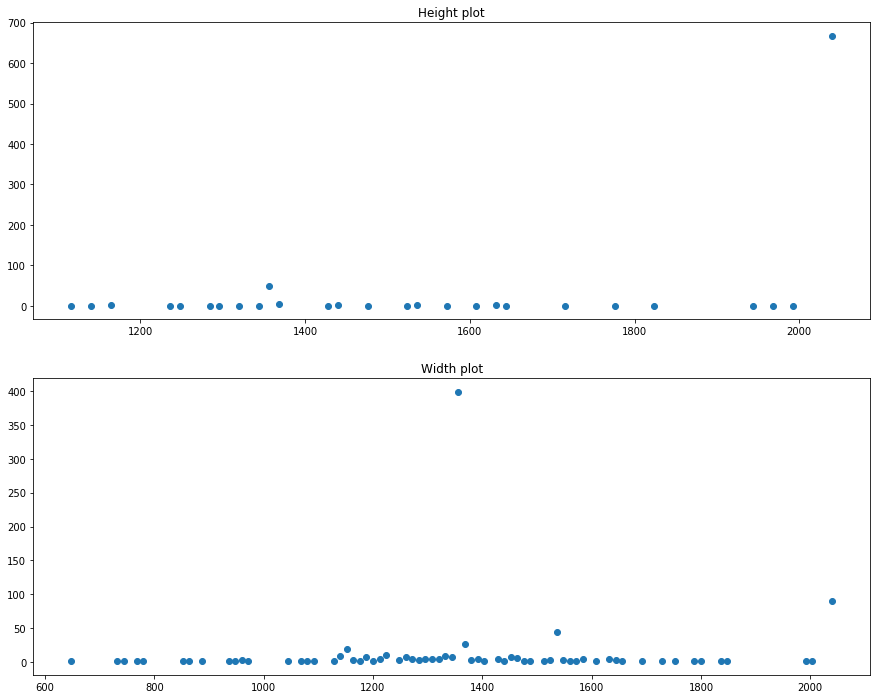

In [7]:
path_train_HR = "/content/Image-SR/train/HR"

mean_h, median_h, mean_w, median_w = explore_dimensions(path_train_HR)

Now I see that most of the heights are 2040 pixels and the widths must be 1356. The width has much more dispersion than the heights. I think if I choose these dimensions I am causing the least distortion to my dataset. In any case I can always change this setting later. Like this I also keep the most common aspect ratio.

In [0]:
input_height = int(median_h) #2040
input_width = int(median_w) #1356

Now resize ONCE. As explained in the docstring of the function resize()

In [0]:
# For the LR files
path_test_LR = "/content/Image-SR/test/LR"
path_train_LR = "/content/Image-SR/train/LR"
path_val_LR = "/content/Image-SR/val/LR"

# I don't make a for loop, this is easy to see and I only have 3 cases.

resize_input(input_height, input_width, path_test_LR)
resize_input(input_height, input_width, path_val_LR)
resize_input(input_height, input_width, path_train_LR)

In [0]:
# For the HR files
path_test_HR = "/content/Image-SR/test/HR"
path_train_HR = "/content/Image-SR/train/HR"
path_val_HR = "/content/Image-SR/val/HR"

# I don't make a for loop, this is easy to see and I only have 3 cases.

resize_input(input_height, input_width, path_test_HR)
resize_input(input_height, input_width, path_val_HR)
resize_input(input_height, input_width, path_train_HR)